C:\Users\navy\AppData\Local\Temp\ipykernel_7440\2909634565.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lon_corr = pearsonr(window['longitude'], np.arange(window_size))[0]
C:\Users\navy\AppData\Local\Temp\ipykernel_7440\2909634565.py:35: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sog_corr = pearsonr(window['sog'], np.arange(window_size))[0]


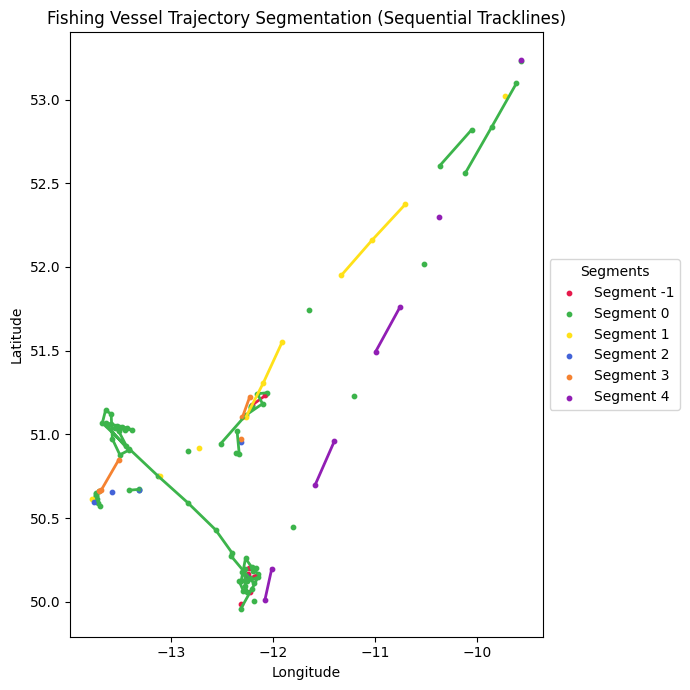

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Load the CSV file into a DataFrame
filepath = r"C:\Users\navy\VMS_DATA\00_Data_WorkingCopies\vessel_trajectories_by_cfr_with_EU_fleet_data\IRL000I10618_with_FleetData.csv"
df = pd.read_csv(filepath)

# Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime
df = df.sort_values(by='datetime')

# Define the row index range
start_index = 24
end_index = 139
df = df.iloc[start_index:end_index]

# Calculate the Pearson correlation coefficient for sliding windows
window_size = 2  # Define your window size
pearson_coeffs = []

for i in range(len(df) - window_size + 1):
    window = df.iloc[i:i + window_size]
    if len(window) < window_size:
        continue
    lat_corr = pearsonr(window['latitude'], np.arange(window_size))[0]
    lon_corr = pearsonr(window['longitude'], np.arange(window_size))[0]
    sog_corr = pearsonr(window['sog'], np.arange(window_size))[0]
    pearson_coeffs.append((lat_corr + lon_corr + sog_corr) / 3)

# Add the Pearson correlation coefficients to the DataFrame
df['pearson_corr'] = [np.nan] * (window_size - 1) + pearson_coeffs

# Calculate accumulated angle for heading
def calculate_accumulated_angle(headings):
    angle_diffs = np.diff(headings)
    angle_diffs = (angle_diffs + 180) % 360 - 180  # Handle circular nature of angles
    accumulated = np.cumsum(np.abs(angle_diffs))
    # Add a 0 at the beginning to maintain the same length as the input
    return np.concatenate(([0], accumulated))

df['accumulated_angle'] = calculate_accumulated_angle(df['heading'])

# Fill NaN values
df.fillna(0, inplace=True)

# Drop rows with NaN values in the initial columns used for Pearson correlation
df = df.dropna(subset=['pearson_corr'])

# Select features for clustering
features = df[['pearson_corr', 'sog', 'accumulated_angle']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply DBSCAN
db = DBSCAN(eps=1, min_samples=4).fit(features_scaled)

# Add cluster labels to the DataFrame
df['segment'] = db.labels_

# Define a set of distinct colors
distinct_colors = [
    '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', 
    '#f032e6', '#bfef45', '#fabed4', '#469990', '#dcbeff', '#9A6324', '#fffac8', 
    '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9'
]

# Plot the trajectory with segment labels
fig, ax = plt.subplots(figsize=(7, 7))

# Get unique segments
unique_segments = sorted(df['segment'].unique())

# Function to split dataframe into sequential groups
def split_sequential(group):
    splits = []
    current_split = [group.iloc[0]]
    
    for i in range(1, len(group)):
        if (group.index[i] - group.index[i-1]) == 1:
            current_split.append(group.iloc[i])
        else:
            splits.append(pd.DataFrame(current_split))
            current_split = [group.iloc[i]]
    
    if current_split:
        splits.append(pd.DataFrame(current_split))
    
    return splits

# Plot tracklines for sequential points in each segment
for i, segment in enumerate(unique_segments):
    segment_data = df[df['segment'] == segment]
    color = distinct_colors[i % len(distinct_colors)]
    
    # Split the segment data into sequential groups
    sequential_groups = split_sequential(segment_data)
    
    # Plot tracklines for each sequential group
    for group in sequential_groups:
        ax.plot(group['longitude'], group['latitude'], 
                c=color, linewidth=2)
    
    # Plot all points in the segment
    ax.scatter(segment_data['longitude'], segment_data['latitude'], 
               c=color, label=f'Segment {segment}', s=10)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fishing Vessel Trajectory Segmentation (Sequential Tracklines)')
ax.legend(title='Segments', loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent cutting off the legend
plt.tight_layout()

plt.show()